# Blood Cell Atlas from Time Course FLEX Data

## Overview
This notebook processes the time course FLEX single-cell RNA-seq dataset to build a comprehensive blood cell atlas. We analyze cells across multiple donors and time points (0h, 2h, 4h, 6h, 8h, 24h) to identify distinct cell types.

**Key Steps:**
1. Load raw 10X data and extract metadata from cell barcodes
2. Perform quality control and doublet removal
3. Train a DRVI model to learn latent representations while regressing out donor and time-specific signals
4. Identify cell type clusters using Leiden clustering
5. Export the annotated dataset for downstream analysis (e.g., neutrophil-specific analysis)

**Output:** `all_celltypes.h5ad` - A processed dataset with cell type annotations


## 🔧 Setup & Environment

Mount Google Drive and install required packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-misc drvi-py 'scanpy[leiden]'

In [ ]:
!pip uninstall torchvision

In [ ]:
!pip install --upgrade scanpy

In [ ]:
import re
import drvi
import scvi
import numpy
import torch
import scanpy
import pandas
import warnings
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from statsmodels.formula.api import mixedlm, ols
from statsmodels.stats.multitest import multipletests

scvi.settings.seed = 0
warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.12/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.12/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
INFO: Global seed set to 0
INFO:lightning.fabric.utilities.seed:Global seed set to 0


## 📂 Data Loading & Metadata Extraction

Load the raw 10X data and parse cell barcodes to extract metadata (donor, tissue, time point). The barcode format is: `donor_tissue_timepoint.barcode`


In [ ]:
dataset = '/content/drive/My Drive/neutrophills_singlecell/raw/'

In [ ]:
adata = scanpy.read_10x_mtx(dataset)

In [ ]:
obs_idx = adata.obs_names.astype(str)

split_df = obs_idx.to_series(index=adata.obs_names).str.extract(r'^(?P<prefix>[^.]+)\.(?P<barcode>.+)$')

meta_df = split_df['prefix'].str.extract(
    r'^(?P<donor>[^_]+)_(?P<tissue>[^_]+)_(?P<time_point>[^_.]+)$'
)

adata.obs['donor'] = meta_df['donor']
adata.obs['tissue'] = meta_df['tissue']
adata.obs['barcode'] = split_df['barcode']
adata.obs['time_point'] = meta_df['time_point']

ordered_time = ['0h', '2h', '4h', '6h', '8h', '24h']
adata.obs['time_point'] = pandas.Categorical(adata.obs['time_point'], categories=ordered_time, ordered=True)


for col in ['donor', 'tissue', 'time_point']:
    adata.obs[col] = adata.obs[col].astype('category')

adata.obs['capture_batch'] = adata.obs['donor'].astype(str) + '_' + adata.obs['time_point'].astype(str)
adata.obs['capture_batch'] = adata.obs['capture_batch'].astype('category')

adata.var['mito'] = adata.var_names.str.startswith('MT-')
adata.var['hemo'] = adata.var_names.str.contains('^HB[^(P)]')
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

## 🔬 Quality Control Metrics

Calculate QC metrics including mitochondrial, ribosomal, and hemoglobin gene percentages to assess cell quality.


In [ ]:
scanpy.pp.calculate_qc_metrics(adata, qc_vars=['mito', 'ribo', 'hemo'], inplace=True, log1p=True)

## 🎯 Doublet Detection

Use **Scrublet** to compute doublet scores, then apply a **Gaussian Mixture Model (GMM)** with 2 components to classify cells as singlets or doublets. This approach adaptively determines the threshold rather than using a fixed cutoff.


In [ ]:
rates = []

for batch_name, idx in adata.obs.groupby('capture_batch').groups.items():
    n_obs = len(idx)
    rates.append((n_obs * 0.008) / 1000)

avg_doublet_rate = sum(rates) / len(rates)

scanpy.pp.scrublet(adata, expected_doublet_rate=avg_doublet_rate, batch_key='capture_batch')

In [ ]:
scores = adata.obs['doublet_score'].values.reshape(-1, 1) # type: ignore

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(scores)

labels = gmm.predict(scores)

cluster_means = {i: scores[labels == i].mean() for i in numpy.unique(labels)}
doublet_cluster = max(cluster_means, key=cluster_means.get) # type: ignore

adata.obs['predicted_doublet'] = labels == doublet_cluster

## 🧹 Cell & Gene Filtering

Remove low-quality cells and uninformative genes:
- **Genes:** Remove mitochondrial, ribosomal, and specific non-coding RNAs (MALAT1, NEAT1)
- **Cells:** Filter based on gene counts (200-4000), total counts (200-15000), and mitochondrial percentage (<1%)
- **Doublets:** Remove predicted doublets


In [ ]:
mask = ~(adata.var_names.str.startswith('MT-') |
         adata.var_names.str.startswith('RPS') |
         adata.var_names.str.startswith('RPL'))

adata = adata[:, mask].copy() # type: ignore

adata = adata[:, ~adata.var_names.isin(['MALAT1', 'NEAT1'])].copy()

adata = adata[~adata.obs['predicted_doublet']].copy()

adata = adata[
    (adata.obs['n_genes_by_counts'] >= 200) &
    (adata.obs['n_genes_by_counts'] <= 4000) &
    (adata.obs['total_counts'] >= 200) &
    (adata.obs['total_counts'] <= 15000) &
    (adata.obs['pct_counts_mito'] <= 1)
].copy()

## 🧬 Feature Selection

Select the top 2000 highly variable genes using Seurat v3 method, accounting for batch effects. We subset to these genes for modeling to focus on biologically informative features.


In [ ]:
batch = 'capture_batch'

adata.raw = adata.copy() # type: ignore
adata.layers['counts'] = adata.X.copy() # type: ignore

scanpy.pp.highly_variable_genes(
    adata, flavor='seurat_v3', span=1, subset=True,
    batch_key=batch, layer='counts', n_top_genes=2000
)

## 🧠 DRVI Model Training

**DRVI** (Deep Representation learning for Variational Inference) learns a low-dimensional latent representation of cells while regressing out technical covariates (donor and time effects). This allows us to identify cell types based on intrinsic gene expression patterns rather than batch or temporal effects.

- **Latent dimensions:** 16
- **Covariates:** capture_batch (donor × time point)
- **Training:** 40 epochs with early stopping


In [ ]:
batch_key = ['capture_batch']

drvi.model.DRVI.setup_anndata(adata, layer='counts', categorical_covariate_keys=batch_key, is_count_data=True)

model = drvi.model.DRVI(adata, n_latent=16, categorical_covariates=batch_key)

In [ ]:
n_epochs = 40

plan = {'n_epochs_kl_warmup': n_epochs}

model.train(max_epochs=n_epochs, early_stopping=True, early_stopping_patience=10)

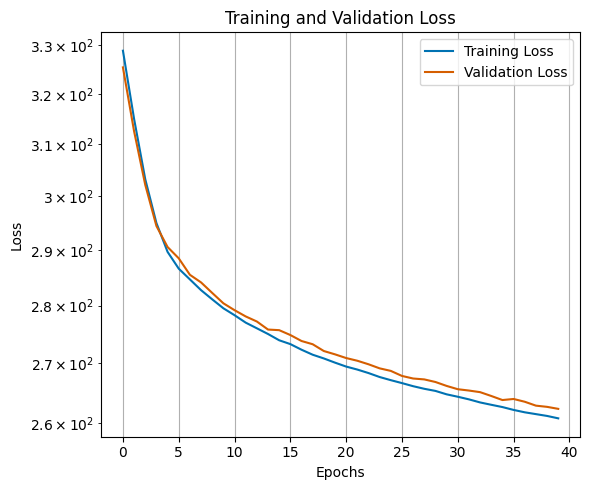

In [ ]:
elbo = model.history['elbo_train'] # type: ignore
elbo['elbo_validation'] = model.history['elbo_validation'] # type:ignore

val_color = '#D55E00'  # Orange
train_color = '#0072B2'  # Blue

# Plotting
plt.figure(figsize=(6, 5))

# Plot Loss
plt.plot(elbo.index,  elbo['elbo_train'], color=train_color, linestyle='-', label='Training Loss')
plt.plot(elbo.index, elbo['elbo_validation'], color=val_color, linestyle='-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()

In [ ]:
model.save('/content/drive/My Drive/neutrophills_singlecell/model.pt', overwrite=True)

adata.obsm['X_drvi'] = model.get_latent_representation() # type: ignore

## 📊 Dimensionality Reduction & Visualization

Compute UMAP embedding from the DRVI latent space using correlation distance for visualization.


In [ ]:
scanpy.pp.neighbors(adata, use_rep='X_drvi', metric='correlation')
scanpy.tl.umap(adata, min_dist=0.3)

## 🔍 Cell Type Clustering

Apply Leiden clustering to identify distinct cell type populations in the DRVI latent space.


In [ ]:
scanpy.tl.leiden(adata, resolution=0.2)

In [ ]:
scanpy.pp.subsample(adata, fraction=1.0)

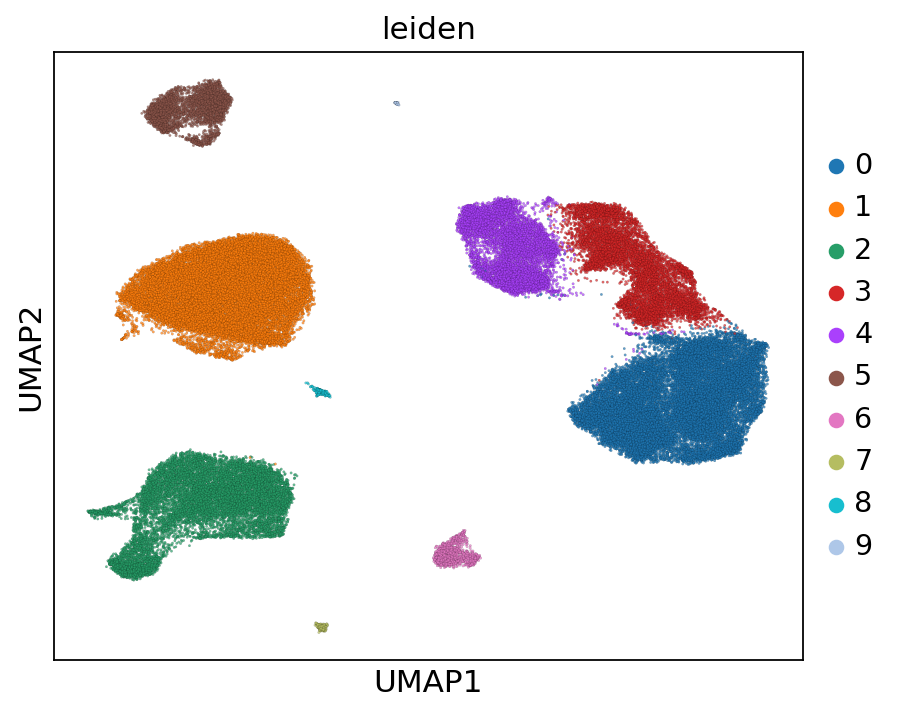

In [ ]:
scanpy.settings.set_figure_params(figsize=(6, 5)) # type: ignore
scanpy.pl.umap(adata, color='leiden', size=5, alpha=0.7, edgecolor='black', linewidth=0.05)

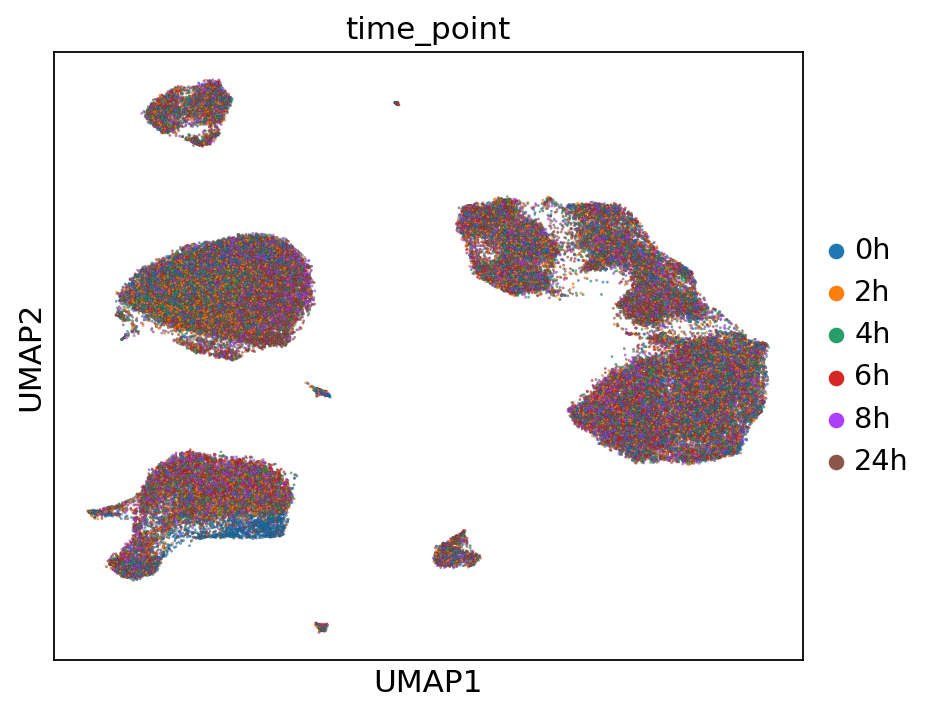

In [ ]:
scanpy.settings.set_figure_params(figsize=(6, 5)) # type: ignore
scanpy.pl.umap(adata, color='time_point', size=5, alpha=0.7, edgecolor='black', linewidth=0.05)

## 🔬 Latent Space Analysis

Analyze the learned latent dimensions to understand which dimensions capture biological variation vs. technical effects. We create an AnnData object from the latent space for interpretability analysis.


In [ ]:
Z = adata.obsm['X_drvi']

n_latent = Z.shape[1]


embed = scanpy.AnnData(
    X=Z,
    obs=adata.obs.copy(),
    var=pandas.DataFrame(index=[f"z{j}" for j in range(n_latent)]),
)

embed.var['original_dim_id'] = numpy.arange(n_latent)

drvi.utils.tl.set_latent_dimension_stats(model, embed)

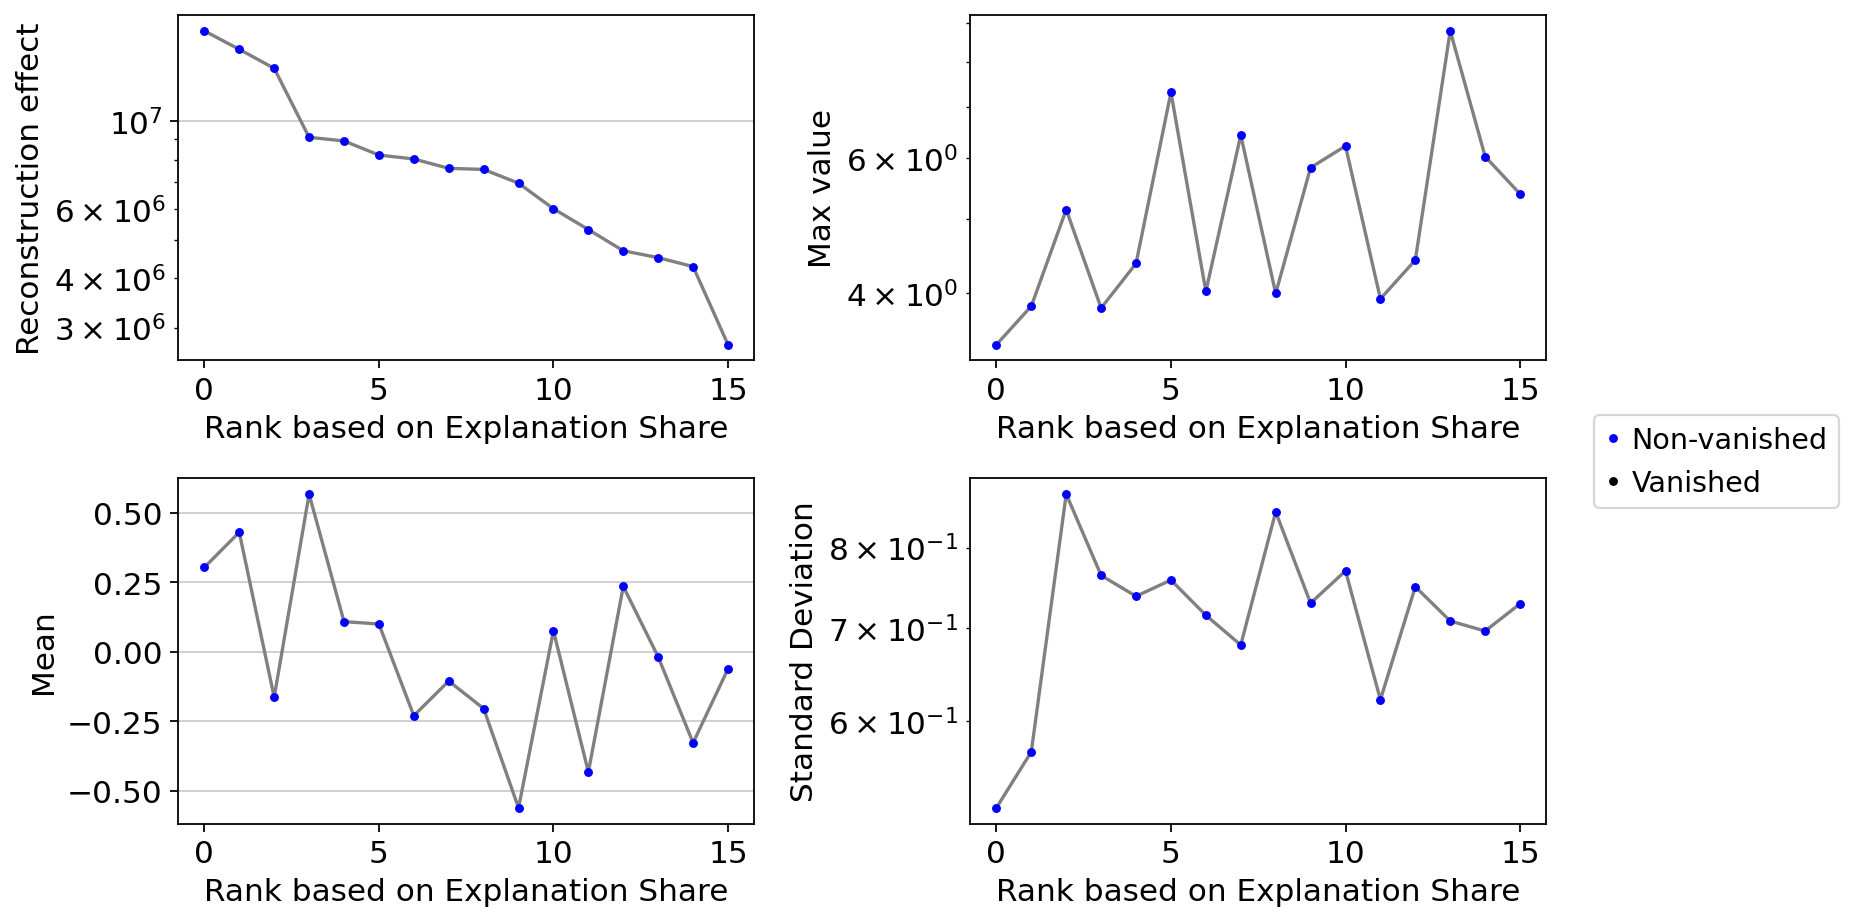

In [ ]:
drvi.utils.pl.plot_latent_dimension_stats(embed, ncols=2)

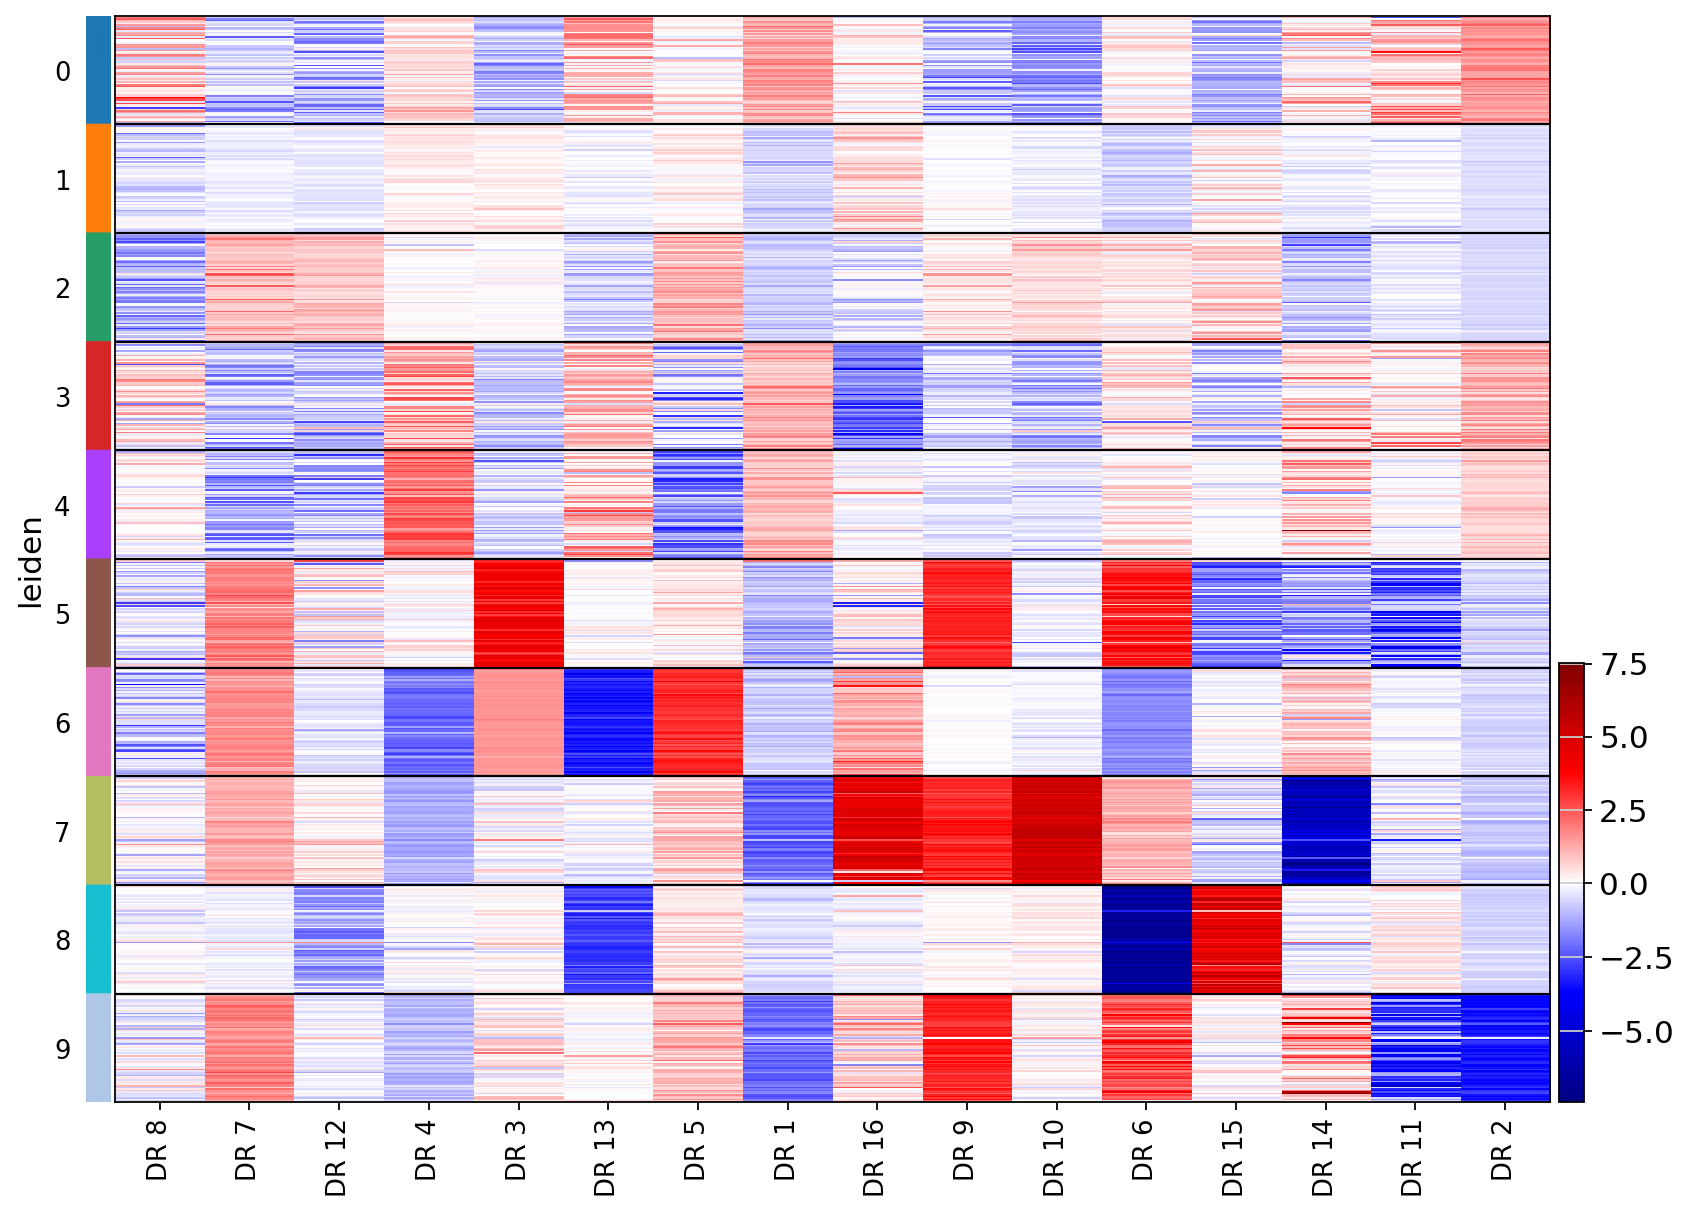

In [ ]:
drvi.utils.pl.plot_latent_dims_in_heatmap(embed, 'leiden', title_col='title', sort_by_categorical=True, figsize=(12, 9))

In [ ]:
traverse_adata = drvi.utils.tl.traverse_latent(model, embed, n_samples=20, max_noise_std=0.0)
drvi.utils.tl.calculate_differential_vars(traverse_adata)

traversing latent ...
Input latent shape: control: (6400, 16), effect: (6400, 16)
Output mean param shape: control: (6400, 2000), effect: (6400, 2000)
Finding differential variables per latent dimension ...


In [ ]:
degs = drvi.utils.tools.iterate_on_top_differential_vars(traverse_adata, 'combined_score') # type: ignore

## 🧬 Gene-Latent Association

Identify top genes associated with each latent dimension by traversing the latent space. This helps interpret what biological programs each dimension represents.


In [ ]:
def drvi_top_table(deg_tuples, top_n=5):
    rows = []
    for label, series in deg_tuples:
        # label looks like 'DR 1-' or 'DR 1+'
        m = re.match(r'^(.*?)([+-])$', str(label).strip())
        if m:
            latent, direction = m.group(1).strip(), m.group(2)
        else:
            latent, direction = str(label).strip(), ''

        # ensure Series and sort descending
        s = pandas.Series(series).sort_values(ascending=False).head(top_n)

        for gene, score in s.items():
            rows.append({
                'gene': str(gene),
                'latent': latent,       # e.g., 'DR 1'
                'direction': direction, # '+' or '-'
                'score': float(score)
            })

    return pandas.DataFrame(rows, columns=['gene', 'latent', 'direction', 'score'])

In [ ]:
top_genes = drvi_top_table(degs)

In [ ]:
top_genes.head(10)

,gene,latent,direction,score
0,CBFA2T3,DR 1,-,17.721949
1,SEMA4A,DR 1,-,5.256924
2,SPI1,DR 1,-,0.344307
3,ALOX5AP,DR 1,-,0.173696
4,P2RX1,DR 1,-,0.099423
5,FAM184A,DR 1,+,4.859323
6,KLHL3,DR 1,+,3.592004
7,RBM11,DR 1,+,3.261424
8,SNPH,DR 1,+,3.022128
9,LGALS1,DR 1,+,2.937678


In [ ]:
top_genes.to_csv('/content/drive/My Drive/neutrophills_singlecell/top_genes_all_celltypes.tsv', sep='\t')

## 📈 Cluster-Latent Associations

Compute correlations between clusters and latent dimensions to identify which latent dimensions best characterize each cell type cluster.


In [ ]:
obsm_key = 'X_drvi'           # DRVI embedding key in adata.obsm
cluster_key = 'leiden'        # cluster column

# latents (cells x dims)
Z = numpy.asarray(adata.obsm[obsm_key])
lat_names = [f'{obsm_key}_{i}' for i in range(Z.shape[1])]

# clusters and names
clusters = adata.obs[cluster_key].astype(str).values
clus_names = sorted(numpy.unique(clusters)) # type: ignore

# correlations per cluster × latent
rows = []

for c in clus_names:
    y = (clusters == c).astype(float)
    r = [numpy.corrcoef(Z[:, j], y)[0, 1] for j in range(Z.shape[1])]
    rows.append(r)

corr_df = pandas.DataFrame(rows, index=clus_names, columns=lat_names)

# ---- build dictionary: cluster -> list of (latent, corr_value) ----
top_k = 2
cluster_to_latents = {
    c: [(lat, float(corr_df.loc[c, lat])) # type: ignore
        for lat in corr_df.loc[c].abs().nlargest(top_k).index] # type: ignore
    for c in corr_df.index
}


In [ ]:
cluster_to_latents

{'0': [('X_drvi_11', 0.7734976406914987), ('X_drvi_13', 0.6786063357004145)],
 '1': [('X_drvi_11', -0.543281868211788), ('X_drvi_13', -0.5000615869176933)],
 '2': [('X_drvi_0', 0.6211309497914302), ('X_drvi_1', 0.521276803830194)],
 '3': [('X_drvi_6', -0.7235655627414916), ('X_drvi_7', 0.3250780286804451)],
 '4': [('X_drvi_7', 0.6645228890667434), ('X_drvi_5', -0.5871065787696723)],
 '5': [('X_drvi_12', 0.7818634435898313), ('X_drvi_4', 0.6918302721143486)],
 '6': [('X_drvi_15', -0.44808924683851675), ('X_drvi_7', -0.3947318225802788)],
 '7': [('X_drvi_3', 0.35451796368033023), ('X_drvi_10', -0.3241597388820618)],
 '8': [('X_drvi_8', -0.32411428084822147), ('X_drvi_14', 0.22677775854637497)],
 '9': [('X_drvi_11', -0.11142583654070234), ('X_drvi_4', 0.09309210294683404)]}

In [ ]:
adata.obs['leiden'].value_counts()

,count
leiden,
0,24121
1,22774
2,12214
3,8736
4,8177
5,3875
6,1250
7,264
8,202


## 💾 Export Processed Data

Save the fully processed and annotated dataset for downstream analysis. This file contains:
- Quality-controlled cells
- DRVI latent representations
- Cell type cluster annotations
- All metadata (donor, time point, etc.)

**Next step:** Use cluster 2 (neutrophils) for temporal analysis in `NeutrophilTimeLatents.ipynb`


In [ ]:
adata.write('/content/drive/My Drive/neutrophills_singlecell/all_celltypes.h5ad')